# In-plane deformation of thin plate based on linear elasticity

This notebook implements the linear elasticity equation where Young's modulus is uncertain and sampled from log-normal like distribution. Dependencies are mentioned in the `neuralop.yml` file in the root directory of this repository. 

## Problem description
Consider a two dimensional domain $\Omega = (0, 1) \times (0, 1) \subset \mathbb{R}^2$ and suppose $u: \Omega \to \mathbf{R}$ denotes the displacement field. The governing equations for the displacmeent field takes the form
\begin{equation}\tag{1}
    \begin{aligned}
        -\nabla \cdot \sigma(x) &= b(x)\,, \qquad & &\forall x\in D_u\,,\\
        \sigma(x) &= \lambda(x) e_{ii} \mathrm{I} + 2\mu(x) e\,, \qquad & & \forall x \in D_u\,,\\
        u(x) &= 0\,,\qquad & & \forall x\in \Gamma_{u_d}\,,\\
        \sigma(x) n(x) &= t(x)\,, \qquad & & \forall x\in \Gamma_{u_q}\,,\\
        \sigma(x) n(x) &= 0\,, \qquad & & \forall x\in \partial D_u - \Gamma_{u_q} - \Gamma_{u_d}\,,\\
    \end{aligned}
\end{equation}
where  $\mathrm{I}$ is the identity second order tensor, and $\lambda$ and $\mu$ are Lam\'e parameters and are related to $E$ and $\nu$ as follows:
\begin{equation}\tag{2}
    \lambda(x) = \frac{E(x) \nu}{(1+\nu)(1-2\nu)} \quad \text{and} \quad \mu(x) = \frac{E(x)}{2(1+\nu)}\,.
\end{equation}
Also, $\Gamma_{u_d} := \left\{x\in \partial D_u: x_1 = 0 \right\}$ and $\Gamma_{u_q} := \left\{x\in \partial D_u: x_1 = L_1 \right\}$, $n$ unit outward normal, and $t$ is the specified traction on the right edge of the domain. We fix
\begin{equation}\tag{3}
     b(x) = 0\hat{e}_1 + 0 \hat{e}_2 \quad \text{and} \quad t(x) = 0\hat{e}_1 + 10 \hat{e}_2\,.
\end{equation}

The probability distribution for $m$ (we denote $E$ by $m$ to be consistent with the notation) is given by
\begin{equation}\tag{4}
    m = \alpha_m * \exp(w) + \beta_m, \qquad \text{where} \quad w \sim N(0, C)\,,
\end{equation}
where $N(0, C)$ denotes the Gaussian measure with the mean function being zero in $L^2(\Omega, \mathbb{R})$ and $C: L^2(\Omega; \mathbb{R}) \times L^2(\Omega; \mathbb{R})\to \mathbb{R}$ is a covariance operator such that $C = L_\Delta^{-2}$, where
\begin{equation}\tag{5}
    L_\Delta := \begin{cases}
        -\mathsf{a}_c \nabla \cdot \mathsf{b}_c \nabla + \mathsf{c}_c\,, \qquad\qquad  &  \text{in } D_w\,,\\
        \gamma n \cdot \mathsf{b}_c \nabla\,, \qquad \qquad & \text{on }\partial D_w\,,
    \end{cases}
\end{equation}
with $\mathsf{a}_c, \mathsf{b}_c, \mathsf{c}_c$ are the parameters and there values including $\alpha_m$ and $\beta_m$ are fixed to
\begin{equation}\tag{6}
\mathsf{a}_c = 0.005\,, \quad \mathsf{b}_c = 1\,, \quad \mathsf{c}_c = 0.2\,,\quad \alpha_m = 100\,, \quad \beta_m = 1000\,.
\end{equation}

Given $m\in M$, we let $F(m) = u\in U$ be the solution of boundary value problem (BVP) Eq (1), i.e., $F: M \to U$ is the solution/forward operator. 

## Random samples of m and corresponding solution u(m)

<p align="center"> <img src="./data/LinearElasticity_sample_plots.png" width="400"> </p>

In [1]:
import sys
import os
import time
import numpy as np
import dolfin as dl

from scipy.interpolate import griddata

src_path = "../../../src/"
sys.path.append(src_path + 'plotting/')
from field_plot import *
from plot_mix_collection import *
from plot_svd import plot_s_vec_values

sys.path.append(src_path + 'pde/')
from fenicsUtilities import function_to_vertex
from meshUtilities import get_dirichlet_bc, get_grid_dirichlet_bc

sys.path.append(src_path + 'prior/')
from priorSampler import PriorSampler

from linearElasticityModel import LinearElasticityModel

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

# set seed
seed = 0
np.random.seed(seed)

In [2]:
data_folder = 'data/'
current_directory = os.getcwd()  
results_dir = current_directory + '/' + data_folder
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

# Create LinearElasticityModel and test prior

In [3]:
prior_ac = 0.005
prior_cc = 0.2
prior_logn_scale = 100.
prior_logn_translate = 1000.
nx, ny = 50, 50
fe_order = 1
data_prefix = 'LinearElasticity'

# create mesh
mesh = dl.UnitSquareMesh(nx, ny)

# create function spaces
Vm = dl.FunctionSpace(mesh, 'Lagrange', fe_order)
Vu = dl.VectorFunctionSpace(mesh, "Lagrange", fe_order)

# create prior sampler
prior_sampler = PriorSampler(Vm, prior_ac, prior_cc, seed)

# create model
model = LinearElasticityModel(Vm, Vu, prior_sampler, prior_logn_scale, prior_logn_translate, seed)

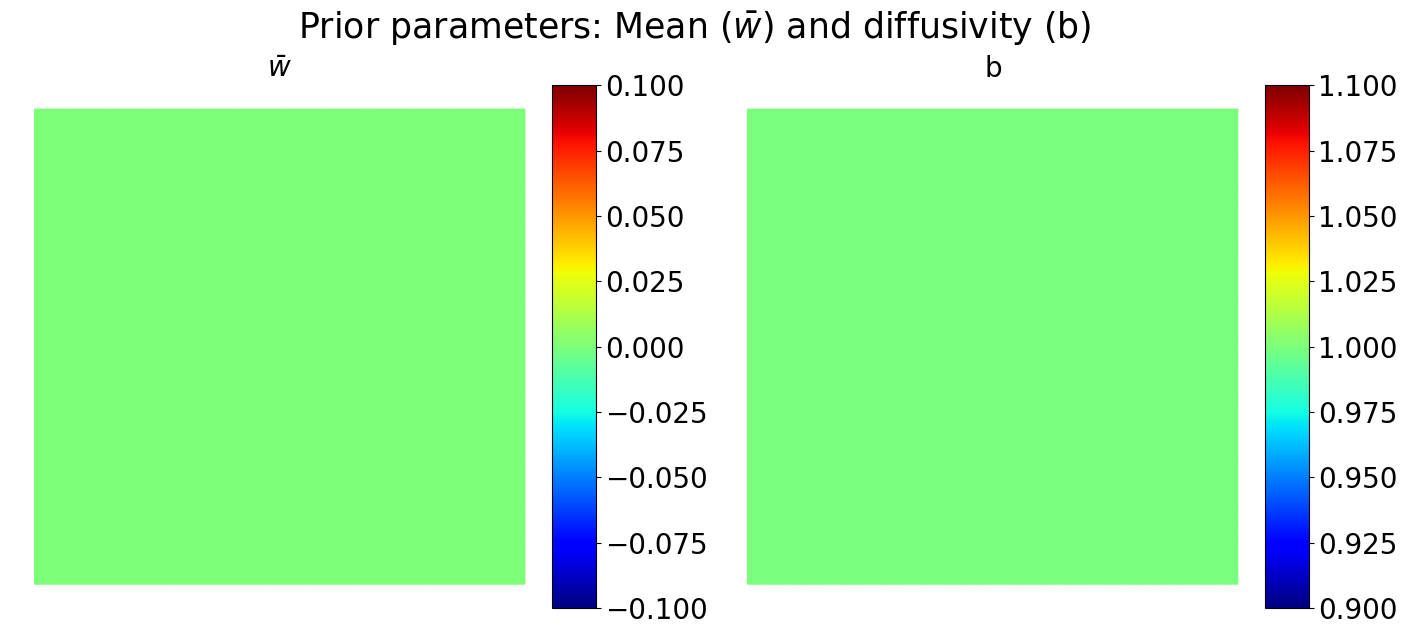

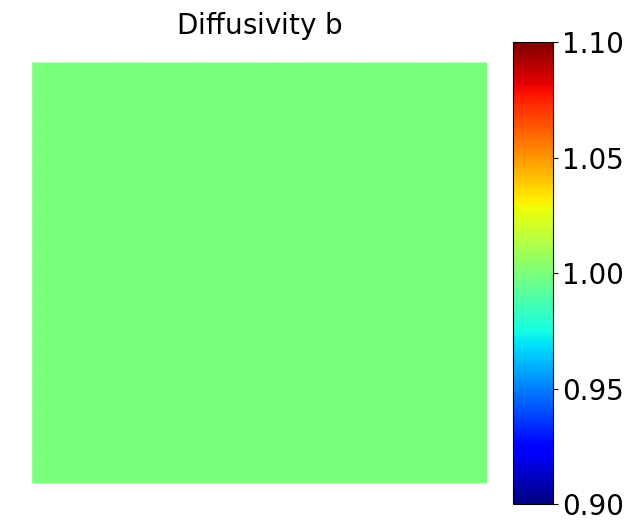

In [4]:
fs = 20
rows, cols = 1, 2
fig, axs = plt.subplots(rows, cols, figsize=(14, 6))
axs = np.array([axs]) if rows == 1 else axs
stats = []
m = prior_sampler.empty_sample()

for i in range(rows):
    for j in range(cols):
        
        m = prior_sampler.mean if j == 0 else prior_sampler.function_to_vertex(prior_sampler.b_fn, None)
        # plot
        cbar = field_plot(axs[i,j], \
                  m, \
                  prior_sampler.V.mesh().coordinates(), cmap = 'jet')
        divider = make_axes_locatable(axs[i,j])
        cax = divider.append_axes('right', size='8%', pad=0.03)
        cax.tick_params(labelsize=fs)
        cbar = fig.colorbar(cbar, cax=cax, orientation='vertical')

        axs[i,j].set_title(r'$\bar{w}$' if j == 0 else r'$\mathsf{b}$', fontsize=fs)
        axs[i,j].axis('off')

fig.tight_layout()
fig.suptitle(r'Prior parameters: Mean ($\bar{w}$) and diffusivity ($\mathsf{b}$)', fontsize=1.25*fs, y = 1.05)
plt.savefig(results_dir + 'prior_parameters.png',  bbox_inches='tight')
plt.show()

quick_field_plot(prior_sampler.function_to_vertex(prior_sampler.b_fn, None), prior_sampler.V.mesh().coordinates(), title = r'Diffusivity $\mathsf{b}$', cmap ='jet', figsize=(7, 6), fs = 20, savefilename=results_dir + 'prior_b.png')

Statistics of all samples
Mean: min = -4.92e-01, max = 4.75e-01, mean = -8.14e-03, std = 1.85e-01, log_prior = -7.01e-01


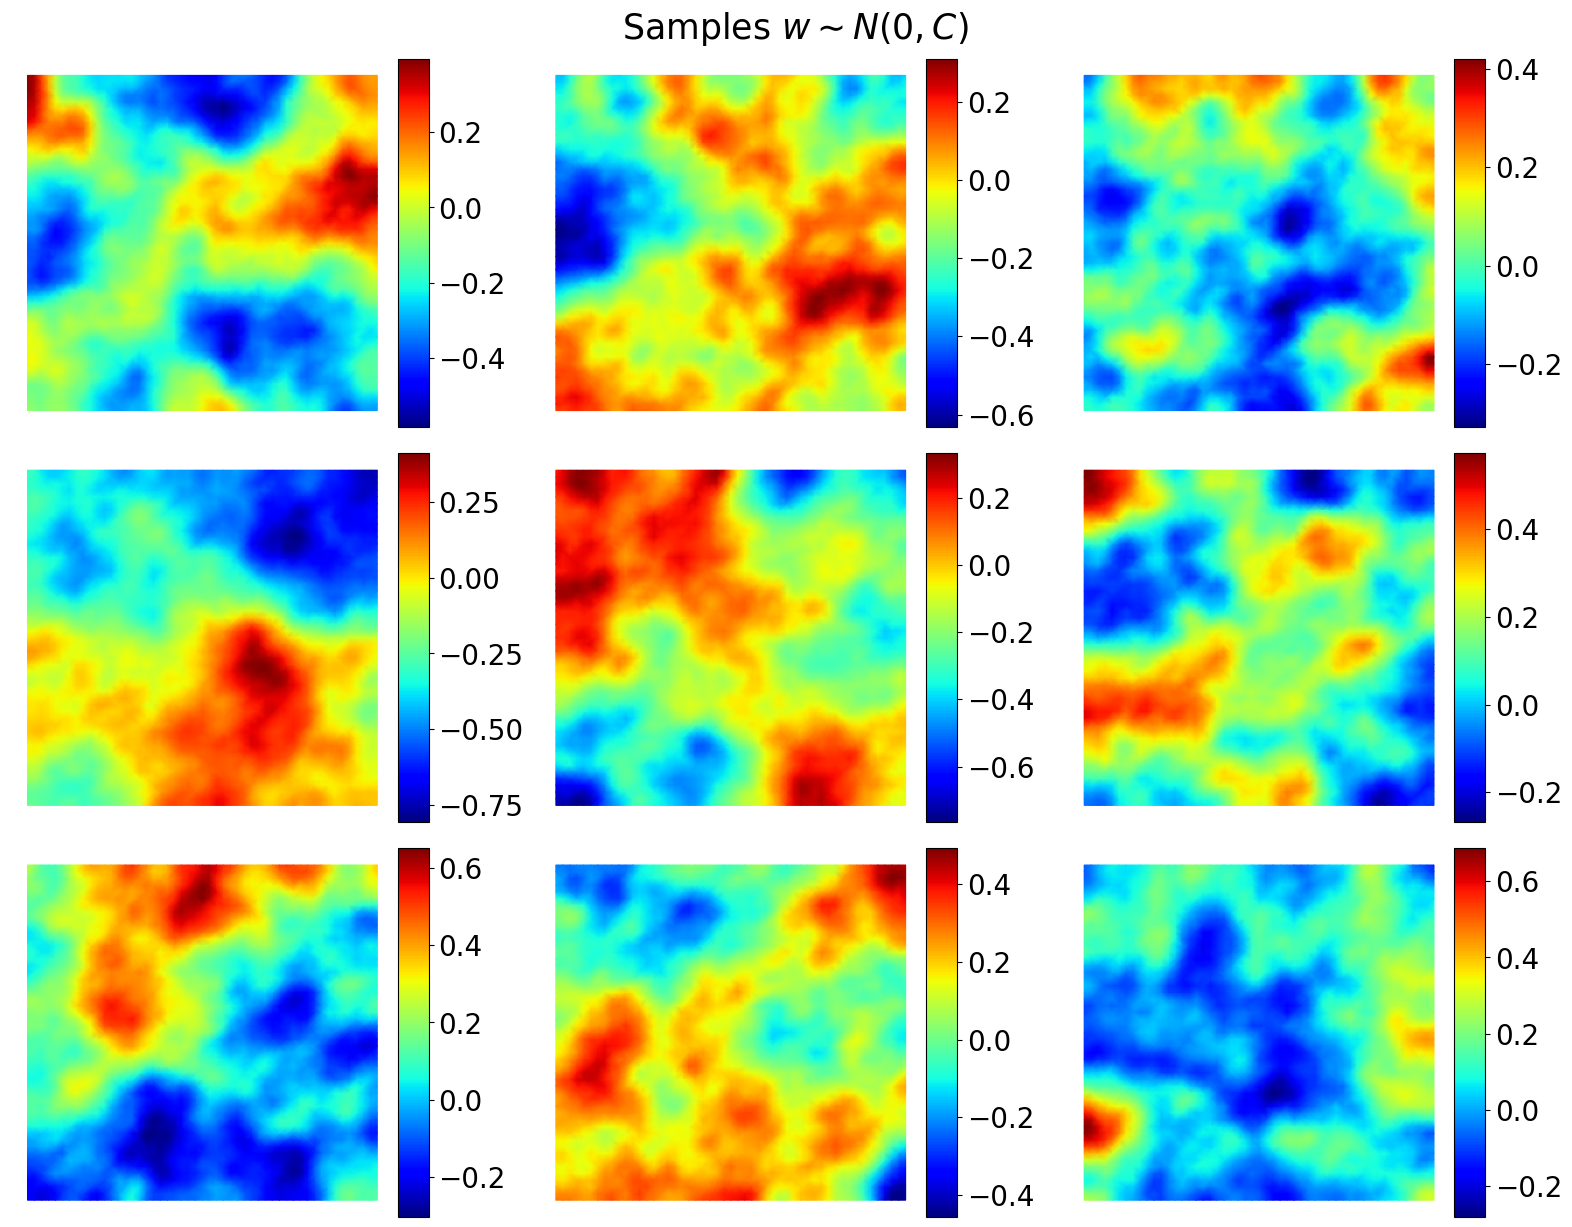

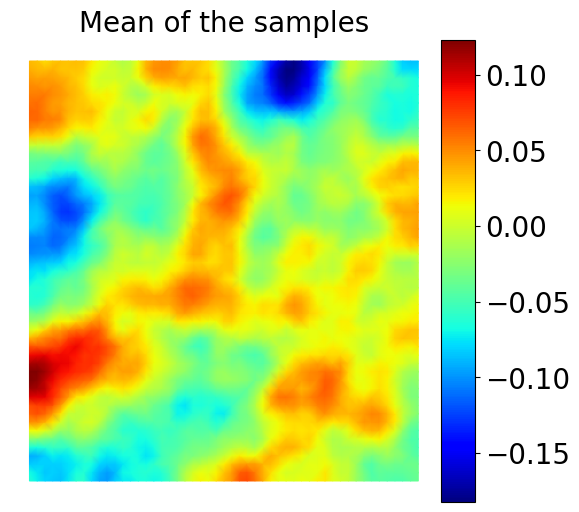

CPU times: user 45.5 s, sys: 85.4 ms, total: 45.6 s
Wall time: 3.85 s


In [5]:
%%time 

fs = 20
rows, cols = 3, 3
fig, axs = plt.subplots(rows, cols, figsize=(16, 12))
stats = []
mvec = []
print_info = False
m = model.prior_sampler.empty_sample()
for i in range(rows):
    for j in range(cols):
        # draw a sample
        m, log_prior = model.prior_sampler(m)

        mvec.append(m)
        stats.append([np.min(m), np.max(m), np.mean(m), np.std(m), log_prior])
        if print_info:
            print('Sample: {:2d}, log_prior = {:.2e}, min = {:.2e}, max = {:.2e}, mean = {:.2e}, std = {:.2e}'.format(i*cols + j, log_prior, np.min(m), np.max(m), np.mean(m), np.std(m)))

        # plot
        cbar = field_plot(axs[i,j], \
                  m, \
                  model.m_nodes, cmap = 'jet')
        divider = make_axes_locatable(axs[i,j])
        cax = divider.append_axes('right', size='8%', pad=0.03)
        cax.tick_params(labelsize=fs)
        cbar = fig.colorbar(cbar, cax=cax, orientation='vertical')
        axs[i,j].axis('off')

# satistics
stats = np.array(stats)
print('Statistics of all samples')
print('Mean: min = {:.2e}, max = {:.2e}, mean = {:.2e}, std = {:.2e}, log_prior = {:.2e}'.format(np.mean(stats[:,0]), np.mean(stats[:,1]), np.mean(stats[:,2]), np.mean(stats[:,3]), np.mean(stats[:,4])))

fig.tight_layout()
fig.suptitle(r'Samples $w\sim N(0,C)$', fontsize=1.25*fs, y = 1.025)
plt.savefig(results_dir + 'prior_samples.png',  bbox_inches='tight')
plt.show()

# compute mean sample field
mvec = np.array(mvec)
m = np.mean(mvec, axis=0)
quick_field_plot(m, model.m_nodes, title='Mean of the samples', cmap ='jet')


# Test LinearElasticity model

## Generate few samples of Youngs modulus and solve the forward problem

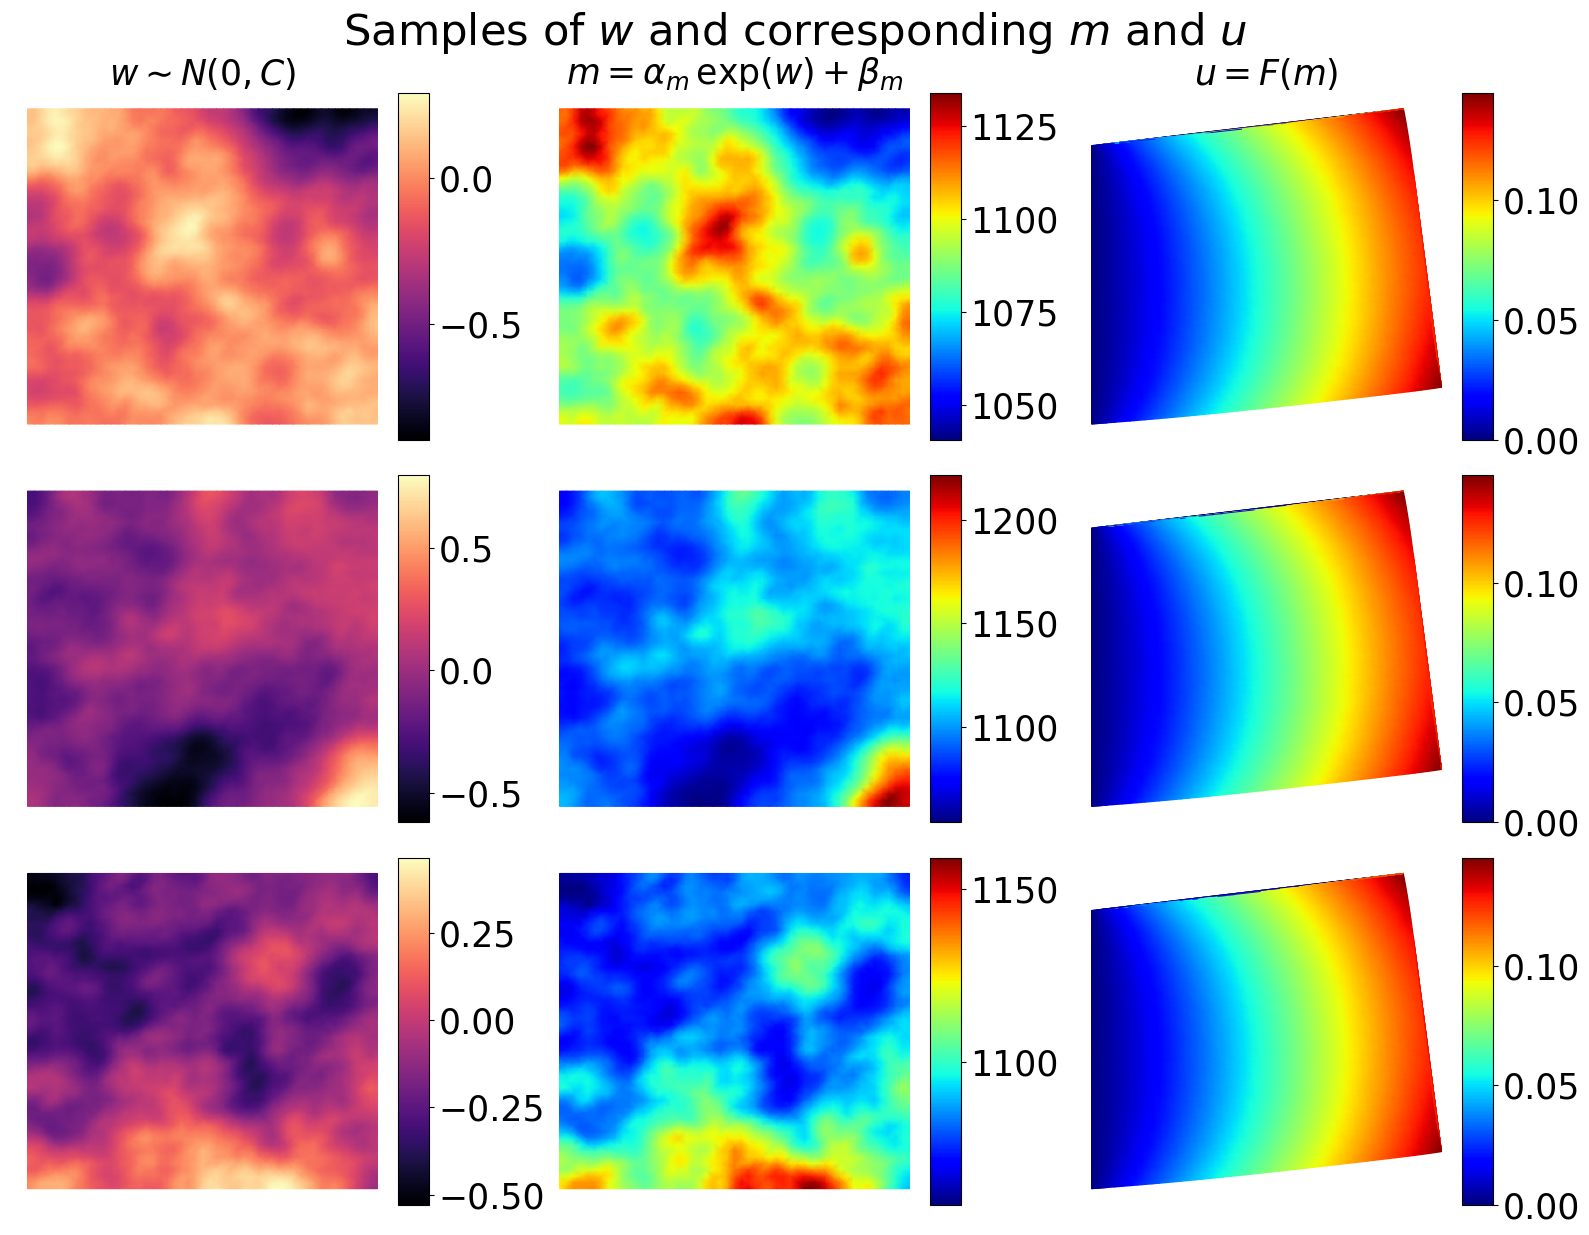

In [6]:
n_test_samples = 3

u_vec = []
title_vec = []
cmapvec = []
flag_is_vec = []
flag_add_disp = []
plot_type = []
for i in range(n_test_samples): 
    cmapvec.append(['magma', 'jet', 'jet'])
    if i == 0:
        title_vec.append([r'$w \sim N(0, C)$', r'$m = \alpha_m\, \exp(w) + \beta_m$', r'$u = F(m)$'])
    else:
        title_vec.append([None, None, None])
    
    flag_is_vec.append([False, False, True])
    flag_add_disp.append([False, False, True])
    plot_type.append(['field' for i in range(3)])

w = model.empty_m()
m = model.empty_m()
u = model.empty_u()

for i in range(n_test_samples):

    # draw a sample
    w, log_prior = model.prior_sampler(w)

    # transform w to m
    # m = model.m_mean
    m = model.transform_gaussian_pointwise(w, m)    
    
    # solve
    u = model.solveFwd(u, m, transform_m = False)

    ## ----------------- ##
    # fake displacement to test the plot
    if False:
        num_nodes = model.u_nodes.shape[0]
        for k in range(num_nodes):
            u[k] = 0.1 * (i + 1) * np.linalg.norm(model.u_nodes[k])
            u[num_nodes+k] = 0.1 * (i + 1) * np.linalg.norm(model.u_nodes[k])
    ## ----------------- ##
    
    u_vec.append([w, m, u])

# plot all samples
plot_data = get_default_plot_mix_collection_data(rows = n_test_samples, \
    cols = 3, \
    nodes = model.u_nodes, \
    figsize = (16, 12), fs = 25, \
    sup_title = r'Samples of $w$ and corresponding $m$ and $u$', \
    y_sup_title = 1.025, \
    savefilename = None, \
    u = u_vec, cmap = cmapvec, title = title_vec, \
    is_vec = flag_is_vec, add_disp = flag_add_disp, \
    plot_type = plot_type)

plot_mix_collection(plot_data)

In [7]:
a = model.m_mean
print('stats of mean of m:', a.mean(), a.min(), a.max())
a = model.samplePrior(a, transform_m = True)
print('stats of sample of m:', a.mean(), a.min(), a.max())

stats of mean of m: 1100.0 1100.0 1100.0
stats of sample of m: 1100.0301951790784 1050.6291352229855 1138.9933756677983


## Locate the nodes on the Dirichlet boundary

In [8]:
u_mesh_dirichlet_boundary_nodes = get_dirichlet_bc(model.is_point_on_dirichlet_boundary, model.u_nodes)

print(u_mesh_dirichlet_boundary_nodes.shape, u_mesh_dirichlet_boundary_nodes)

# verify that the boundary nodes are correct
n_test_samples = 10

for i in range(n_test_samples):

    u = model.solveFwd(m = model.samplePrior(transform_m = True), transform_m = False)

    ub_x, ub_y = u[u_mesh_dirichlet_boundary_nodes], u[model.u_nodes.shape[0] + u_mesh_dirichlet_boundary_nodes]

    bc_x_err = np.linalg.norm(ub_x)
    bc_y_err = np.linalg.norm(ub_y)
    print('bc_x_err = {:.2e}, bc_y_err = {:.2e}'.format(bc_x_err, bc_y_err))

(51,) [   0   51  102  153  204  255  306  357  408  459  510  561  612  663
  714  765  816  867  918  969 1020 1071 1122 1173 1224 1275 1326 1377
 1428 1479 1530 1581 1632 1683 1734 1785 1836 1887 1938 1989 2040 2091
 2142 2193 2244 2295 2346 2397 2448 2499 2550]
bc_x_err = 0.00e+00, bc_y_err = 0.00e+00
bc_x_err = 0.00e+00, bc_y_err = 0.00e+00
bc_x_err = 0.00e+00, bc_y_err = 0.00e+00
bc_x_err = 0.00e+00, bc_y_err = 0.00e+00
bc_x_err = 0.00e+00, bc_y_err = 0.00e+00
bc_x_err = 0.00e+00, bc_y_err = 0.00e+00
bc_x_err = 0.00e+00, bc_y_err = 0.00e+00
bc_x_err = 0.00e+00, bc_y_err = 0.00e+00
bc_x_err = 0.00e+00, bc_y_err = 0.00e+00
bc_x_err = 0.00e+00, bc_y_err = 0.00e+00


## Generate data

In [9]:
generate_data = False
if generate_data:
    num_samples = 5000

    w_samples = np.zeros((num_samples, model.m_dim))
    m_samples = np.zeros((num_samples, model.m_dim))
    u_samples = np.zeros((num_samples, model.u_dim))

    w, m, u = model.empty_m(), model.empty_m(), model.empty_u()

    for i in range(num_samples):

        start_time = time.perf_counter()

        # draw from gaussian prior
        if i == 0:
            w = prior_sampler.mean.copy()
        else:
            w = prior_sampler(w)[0]
        
        # transform w to m
        m = model.transform_gaussian_pointwise(w, m)
        
        # if m is transformed above, we do not need to transform it again
        u = model.solveFwd(u, m, transform_m = False)

        # save
        w_samples[i, :] = w
        m_samples[i, :] = m
        u_samples[i, :] = u

        end_time = time.perf_counter()
        sample_time = end_time - start_time

        if i % 100 == 0:
            print('Sample {:4d} took {:.3f} seconds'.format(i, sample_time))

    print(m_samples.shape, m_samples.shape, u_samples.shape)

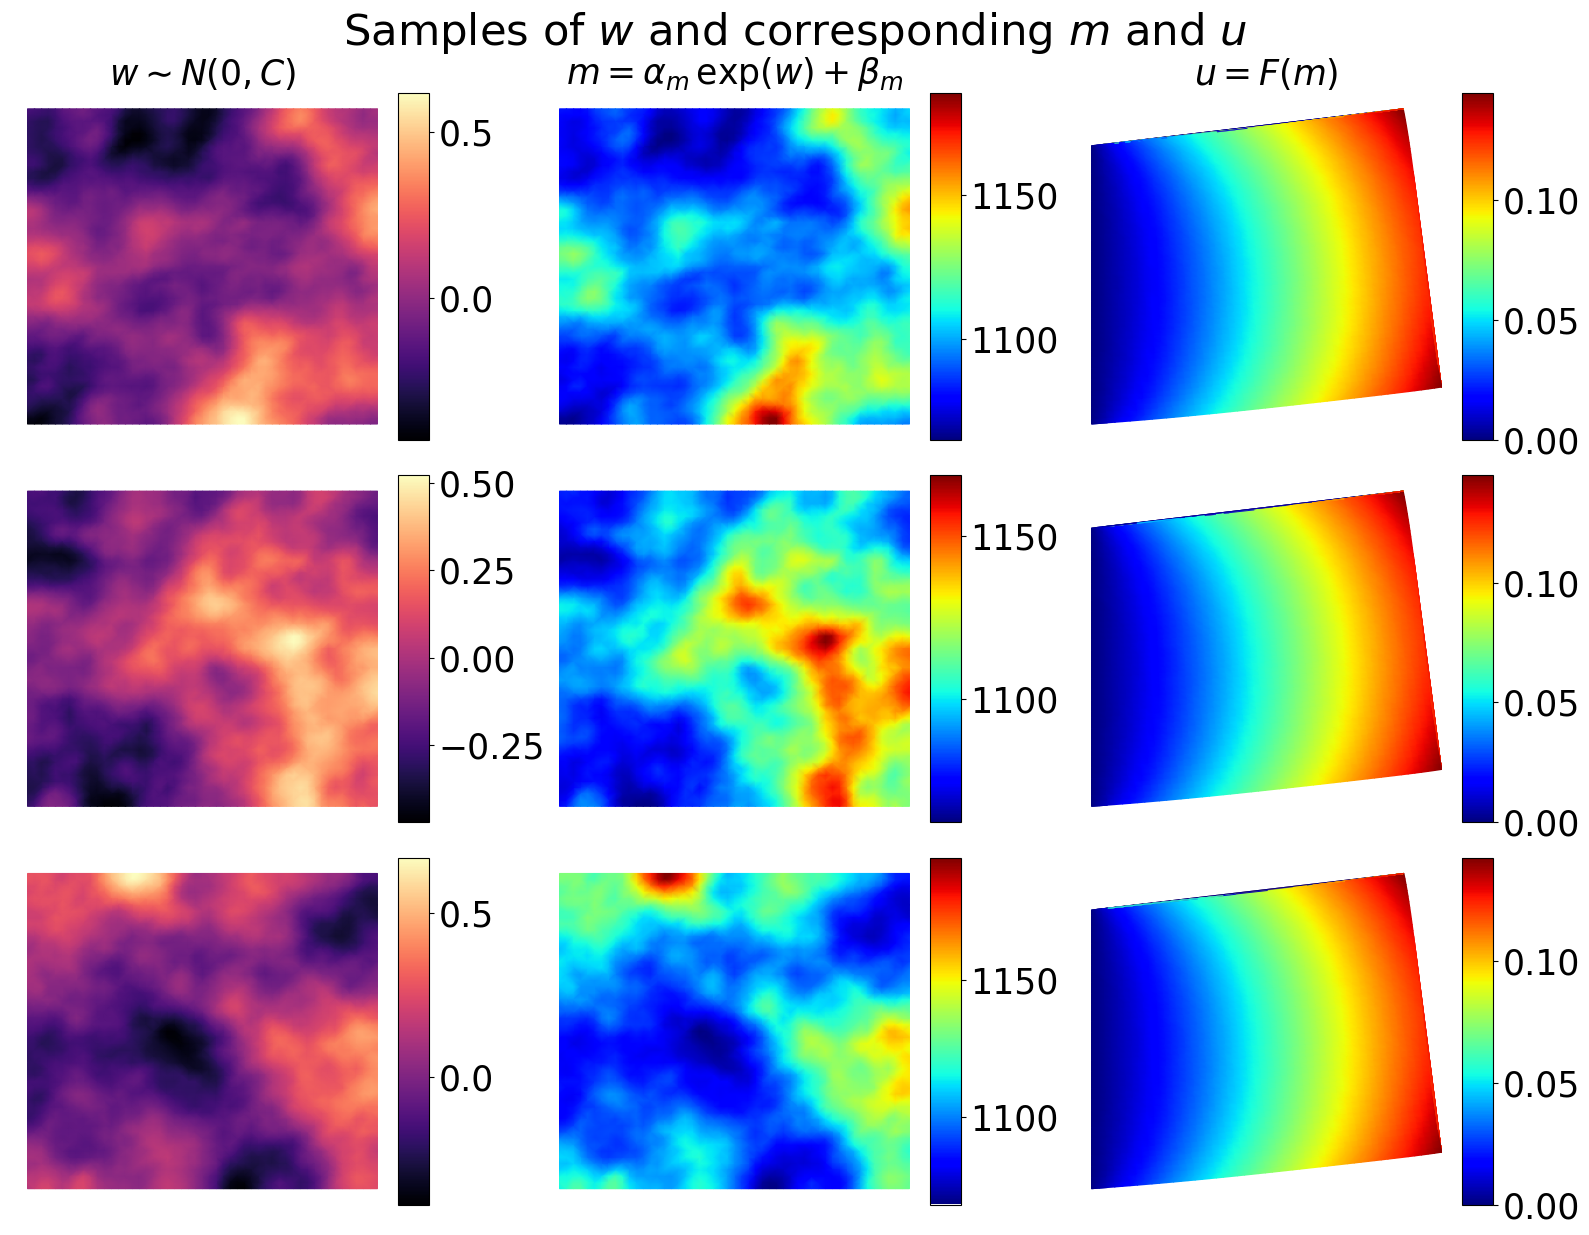

In [10]:
plot_from_data = True
if plot_from_data:
    if generate_data == False:
        data_load = np.load(results_dir + data_prefix + '_samples.npz')
        w_samples = data_load['w_samples']
        m_samples = data_load['m_samples']
        u_samples = data_load['u_samples']
    
    i_choices = np.random.choice(w_samples.shape[0], 3, replace=False)

    n_test_samples = len(i_choices)

    u_vec = []
    title_vec = []
    cmapvec = []
    flag_is_vec = []
    flag_add_disp = []
    plot_type = []
    for i in range(n_test_samples): 
        cmapvec.append(['magma', 'jet', 'jet'])
        if i == 0:
            title_vec.append([r'$w \sim N(0, C)$', r'$m = \alpha_m\, \exp(w) + \beta_m$', r'$u = F(m)$'])
        else:
            title_vec.append([None, None, None])
        
        flag_is_vec.append([False, False, True])
        flag_add_disp.append([False, False, True])
        plot_type.append(['field' for i in range(3)])

        ii = i_choices[i]
        u_vec.append([w_samples[ii, :], m_samples[ii, :], u_samples[ii, :]])


    # plot all samples
    plot_data = get_default_plot_mix_collection_data(rows = n_test_samples, \
        cols = 3, \
        nodes = model.u_nodes, \
        figsize = (16, 12), fs = 25, \
        sup_title = r'Samples of $w$ and corresponding $m$ and $u$', \
        y_sup_title = 1.025, \
        savefilename = results_dir + data_prefix + '_sample_plots.png', \
        u = u_vec, cmap = cmapvec, title = title_vec, \
        is_vec = flag_is_vec, add_disp = flag_add_disp, \
        plot_type = plot_type)

    plot_mix_collection(plot_data)

In [11]:
if True:
    # analyze SVD of the data
    proj_w_dim, proj_m_dim, proj_u_dim = 100, 100, 100
    tol = 1.e-9
    if generate_data is False:
        data = np.load(results_dir + data_prefix + '_samples.npz')
        w_samples = data['w_samples']
        m_samples = data['m_samples']
        u_samples = data['u_samples']
        w_SVD = data['w_SVD']
        m_SVD = data['m_SVD']
        u_SVD = data['u_SVD']
        w_s = data['w_s']
        m_s = data['m_s']
        u_s = data['u_s']
    else:
        w_mean = np.mean(w_samples, axis = 0)
        m_mean = np.mean(m_samples, axis = 0)
        u_mean = np.mean(u_samples, axis = 0)
        w_std = np.std(w_samples, axis = 0)
        m_std = np.std(m_samples, axis = 0)
        u_std = np.std(u_samples, axis = 0)
        w_normalized = (w_samples - w_mean) / (w_std + tol)
        m_normalized = (m_samples - m_mean) / (m_std + tol)
        u_normalized = (u_samples - u_mean) / (u_std + tol)
        w_SVD, w_s, _ = np.linalg.svd(w_normalized.T, full_matrices = False)
        m_SVD, m_s, _ = np.linalg.svd(m_normalized.T, full_matrices = False)
        u_SVD, u_s, _ = np.linalg.svd(u_normalized.T, full_matrices = False)


j = 0, i = 0, index = 100, index_val = 0.03228795731430402
j = 0, i = 1, index = 100, index_val = 0.03282037002900253
j = 0, i = 2, index = 100, index_val = 0.0013229600921200126
j = 1, i = 0, index = 34, index_val = 0.1003281913679788
j = 1, i = 1, index = 35, index_val = 0.10036685738825374
j = 1, i = 2, index = 6, index_val = 0.07934391444687204
j = 2, i = 0, index = 285, index_val = 0.010017392684868698
j = 2, i = 1, index = 290, index_val = 0.010022420429417771
j = 2, i = 2, index = 29, index_val = 0.010071149972324544


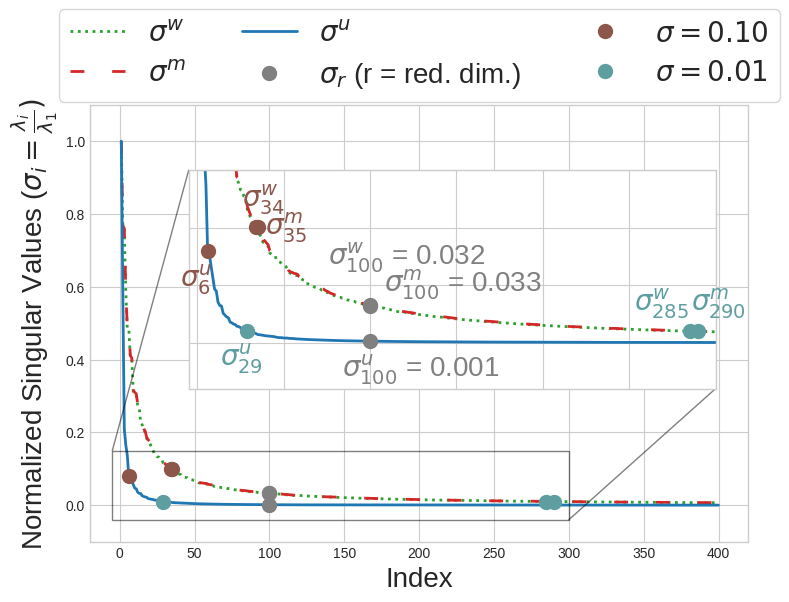

j = 0, i = 0, index = 100, index_val = 0.03282037002900253
j = 0, i = 1, index = 100, index_val = 0.0013229600921200126
j = 1, i = 0, index = 35, index_val = 0.10036685738825374
j = 1, i = 1, index = 6, index_val = 0.07934391444687204
j = 2, i = 0, index = 290, index_val = 0.010022420429417771
j = 2, i = 1, index = 29, index_val = 0.010071149972324544


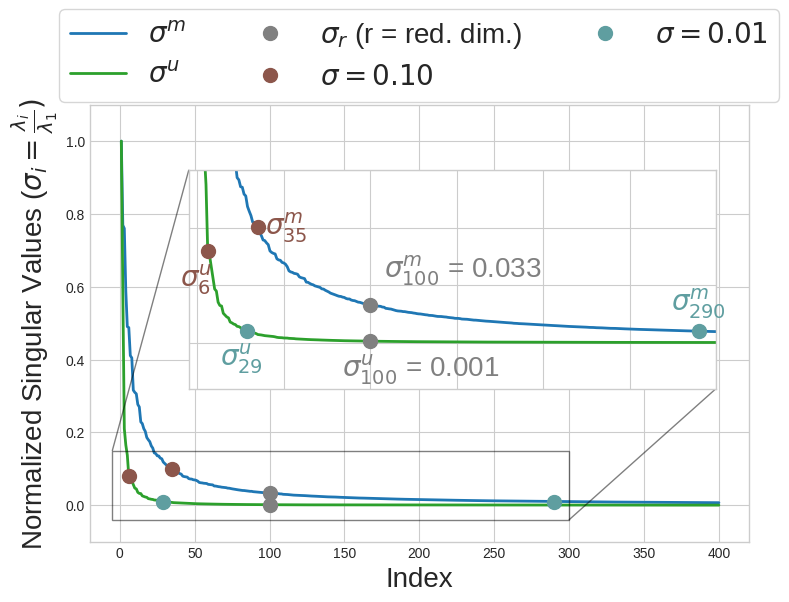

In [12]:
if True:
    plot_annot_xy = [0.15, 0.35, 0.8, 0.5]
    plot_annot_xy_region = [-5, 300, -0.04, 0.15]
    xy_text_vec = []
    xy_text_vec.append([(-30, 30), (10, 10), (-20, -25)])
    xy_text_vec.append([(-10, 15), (5, -5), (-20, -25)])
    xy_text_vec.append([(-40, 15), (-5, 15), (-20, -25)])
    l_style_vec = [':', (0, (5, 10)), '-', '.']

    plot_s_vec_values([w_s, m_s, u_s], [proj_w_dim, proj_m_dim, proj_u_dim], \
                      ['w', 'm', 'u'], \
                      l_style_vec, \
                      xy_text_vec, \
                      plot_annot_xy, \
                      plot_annot_xy_region, \
                      results_dir + data_prefix + '_svd_analysis_w_m_u')

    xy_text_vec = []
    xy_text_vec.append([(10, 20), (-20, -25)])
    xy_text_vec.append([(5, -5), (-20, -25)])
    xy_text_vec.append([(-20, 15), (-20, -25)])
    l_style_vec = ['-', '-']
    plot_s_vec_values([m_s, u_s], [proj_m_dim, proj_u_dim], \
                      ['m', 'u'], \
                      l_style_vec, \
                      xy_text_vec, \
                      plot_annot_xy, \
                      plot_annot_xy_region, \
                      results_dir + data_prefix + '_svd_analysis_m_u')

In [13]:
if generate_data:
    u_mesh_dirichlet_boundary_nodes = get_dirichlet_bc(model.is_point_on_dirichlet_boundary, model.u_nodes)

    # data to save
    np.savez(results_dir + data_prefix + '_samples.npz', \
            w_samples = w_samples, \
            m_samples = m_samples, \
            u_samples = u_samples, \
            num_samples = num_samples, \
            m_dim = model.m_dim, u_dim = model.u_dim, \
            fe_order = fe_order, \
            nx = nx, ny = ny, \
            prior_ac = prior_ac, \
            prior_cc = prior_cc, \
            prior_alpham = prior_logn_scale, \
            prior_betam = prior_logn_translate, \
            u_mesh_nodes = model.u_nodes, \
            m_mesh_nodes = model.m_nodes, \
            u_mesh_elements = model.Vu.mesh().cells(), \
            m_mesh_elements = model.Vm.mesh().cells(), \
            u_mesh_dirichlet_boundary_nodes = u_mesh_dirichlet_boundary_nodes, \
            w_SVD = w_SVD, w_s = w_s, \
            m_SVD = m_SVD, m_s = m_s, \
            u_SVD = u_SVD, u_s = u_s)


    # save mesh 
    ## to read, use the syntax
    ## mesh = dl.Mesh()
    ## with dl.XDMFFile(results_dir + 'u_mesh.xdmf') as infile:
    ##     infile.read(mesh)
    with dl.XDMFFile(results_dir + data_prefix + '_u_mesh.xdmf') as infile:
        infile.write(model.Vu.mesh())

    with dl.XDMFFile(results_dir + data_prefix + '_m_mesh.xdmf') as infile:
        infile.write(model.Vm.mesh())

In [14]:
print('m_mesh_nodes shape: {}\nu_mesh_nodes shape: {}\nm_dim: {}\nu_dim: {}'.format(model.m_nodes.shape, model.u_nodes.shape, model.m_dim, model.u_dim))

m_mesh_nodes shape: (2601, 2)
u_mesh_nodes shape: (2601, 2)
m_dim: 2601
u_dim: 5202


## Interpolate function at nodal values to meshgrid for FNO

### Compute and plot interpolation over grid

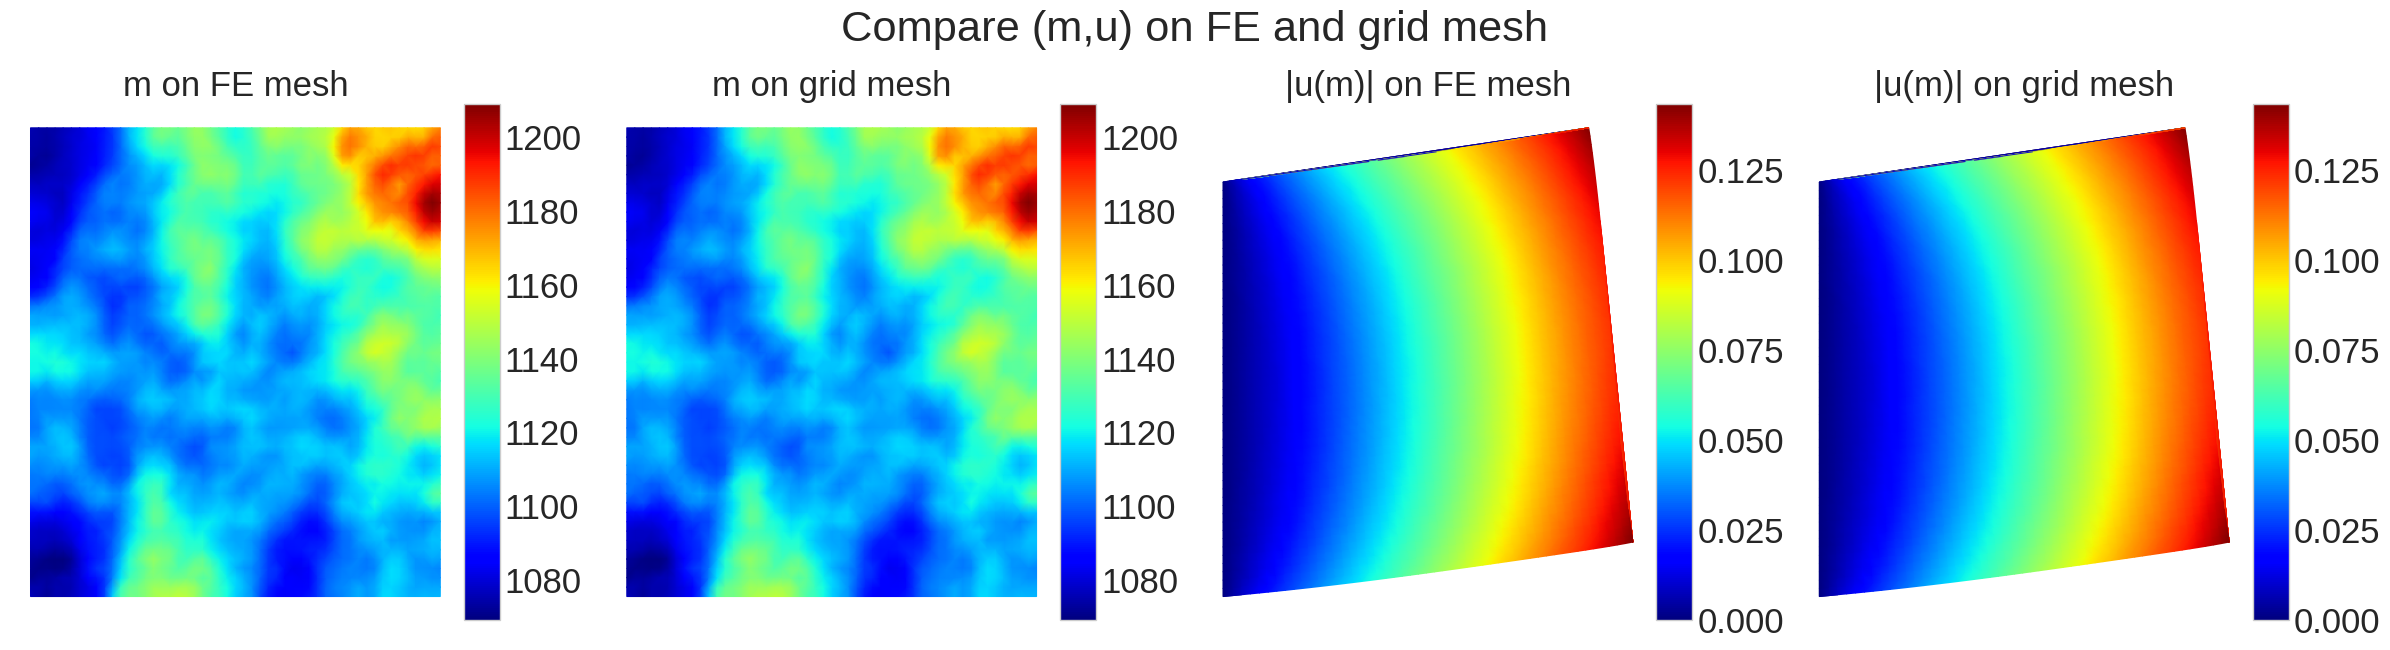

In [15]:
data_load = np.load(results_dir + data_prefix + '_samples.npz')
u_nodes = data_load['u_mesh_nodes']
m_nodes = data_load['m_mesh_nodes']
num_nodes = u_nodes.shape[0]

# get one sample
m = model.samplePrior(transform_m = True)
u = model.solveFwd(u = None, m = m, transform_m = False)

# use interpolation to get data on grid
num_grid_x, num_grid_y = 51, 51
grid_x, grid_y = np.meshgrid(np.linspace(0, 1, num_grid_x), np.linspace(0, 1, num_grid_y), indexing='ij')

# interpolate m and u on grid
grid_m = griddata(m_nodes, m, (grid_x, grid_y), method='linear')
grid_u = np.zeros((num_grid_x, num_grid_y, 2))
grid_u[:, :, 0] = griddata(u_nodes, u[:num_nodes], (grid_x, grid_y), method='linear')
grid_u[:, :, 1] = griddata(u_nodes, u[num_nodes:], (grid_x, grid_y), method='linear')

# plot function on FE mesh and compare with the function on grid

rows = 1
cols = 4
fs = 25
fig, axs = plt.subplots(rows, cols, figsize=(24, 6))

for i in range(cols):
    
    if i%2 == 0:
        # use plotter without element data
        if i == 0:
            cbar = field_plot(axs[i], m, m_nodes, cmap = 'jet')
            axs[i].set_title('m on FE mesh', fontsize = fs)
        else:
            cbar = field_plot(axs[i], \
                        u, \
                        u_nodes, \
                        cmap = 'jet', \
                        add_displacement_to_nodes = True, \
                        is_displacement = True)
            axs[i].set_title('|u(m)| on FE mesh', fontsize = fs)
    else:
        # use griddata
        if i == 1:
            cbar = field_plot_grid(axs[i], grid_m, grid_x, grid_y, cmap = 'jet')
            axs[i].set_title('m on grid mesh', fontsize = fs)
        else:
            cbar = field_plot_grid(axs[i],\
                        grid_u, \
                        grid_x, \
                        grid_y, \
                        cmap = 'jet', \
                        add_displacement_to_nodes = True, \
                        is_displacement = True)
            axs[i].set_title('|u(m)| on grid mesh', fontsize = fs)

    divider = make_axes_locatable(axs[i])
    cax = divider.append_axes('right', size='8%', pad=0.03)
    cax.tick_params(labelsize=fs)

    if i < 2:
        # format cbar ticks
        kfmt = lambda x, pos: "{:g}".format(x)
        
        cbar = fig.colorbar(cbar, cax=cax, orientation='vertical', format = kfmt)
    else:
        cbar = fig.colorbar(cbar, cax=cax, orientation='vertical')

    axs[i].axis('off')

fig.tight_layout()
fig.suptitle('Compare (m,u) on FE and grid mesh', fontsize=1.25*fs, y=1.075)
fig.savefig(results_dir + data_prefix + '_compare_FE_and_grid_mesh.png',  bbox_inches='tight')
plt.show()


### Interpolate all samples to grid and save to file for FNO

In [16]:
# save all samples to file
generate_fno_data = False
if generate_fno_data:

    num_grid_x, num_grid_y = 51, 51
    print('Generating FNO data for grid sizes ({}, {})'.format(num_grid_x, num_grid_y))

    # get grid coordinates
    grid_x, grid_y = np.meshgrid(np.linspace(0, 1, num_grid_x), np.linspace(0, 1, num_grid_y), indexing='ij')

    # load data
    data_load = np.load(results_dir + data_prefix + '_samples.npz')
    
    m_nodes = data_load['m_mesh_nodes']
    u_nodes = data_load['u_mesh_nodes']

    w_samples = data_load['w_samples']
    m_samples = data_load['m_samples']
    u_samples = data_load['u_samples']

    num_samples = m_samples.shape[0]

    # get indices of grid points on the boundary
    u_grid_dirichlet_boundary_nodes = get_grid_dirichlet_bc(model.is_point_on_dirichlet_boundary, grid_x, grid_y)
    
    # interpolate samples on grid
    grid_w_samples = np.zeros((num_samples, num_grid_x, num_grid_y))
    grid_m_samples = np.zeros((num_samples, num_grid_x, num_grid_y))
    grid_u_samples = np.zeros((num_samples, num_grid_x, num_grid_y, 2))
    for i in range(num_samples):
        start_time = time.perf_counter()
        
        grid_w_samples[i, :, :] = griddata(m_nodes, w_samples[i, :], (grid_x, grid_y), method='linear')
        grid_m_samples[i, :, :] = griddata(m_nodes, m_samples[i, :], (grid_x, grid_y), method='linear')
        grid_u_samples[i, :, :, 0] = griddata(u_nodes, u_samples[i, :num_nodes], (grid_x, grid_y), method='linear')
        grid_u_samples[i, :, :, 1] = griddata(u_nodes, u_samples[i, num_nodes:], (grid_x, grid_y), method='linear')

        # explicity set boundary points to zero (not necessary as the solution of PDE is zero on the boundary)
        grid_u_samples[i, u_grid_dirichlet_boundary_nodes[:,0], u_grid_dirichlet_boundary_nodes[:,1], 0] = 0.0
        grid_u_samples[i, u_grid_dirichlet_boundary_nodes[:,0], u_grid_dirichlet_boundary_nodes[:,1], 1] = 0.0

        end_time = time.perf_counter()
        sample_time = end_time - start_time

        if i % 100 == 0:
            print('Sample {:4d} took {:.3f} seconds'.format(i, sample_time))

    print(grid_m_samples.shape, grid_u_samples.shape)

grid_u_samples shape: (5000, 51, 51, 2)


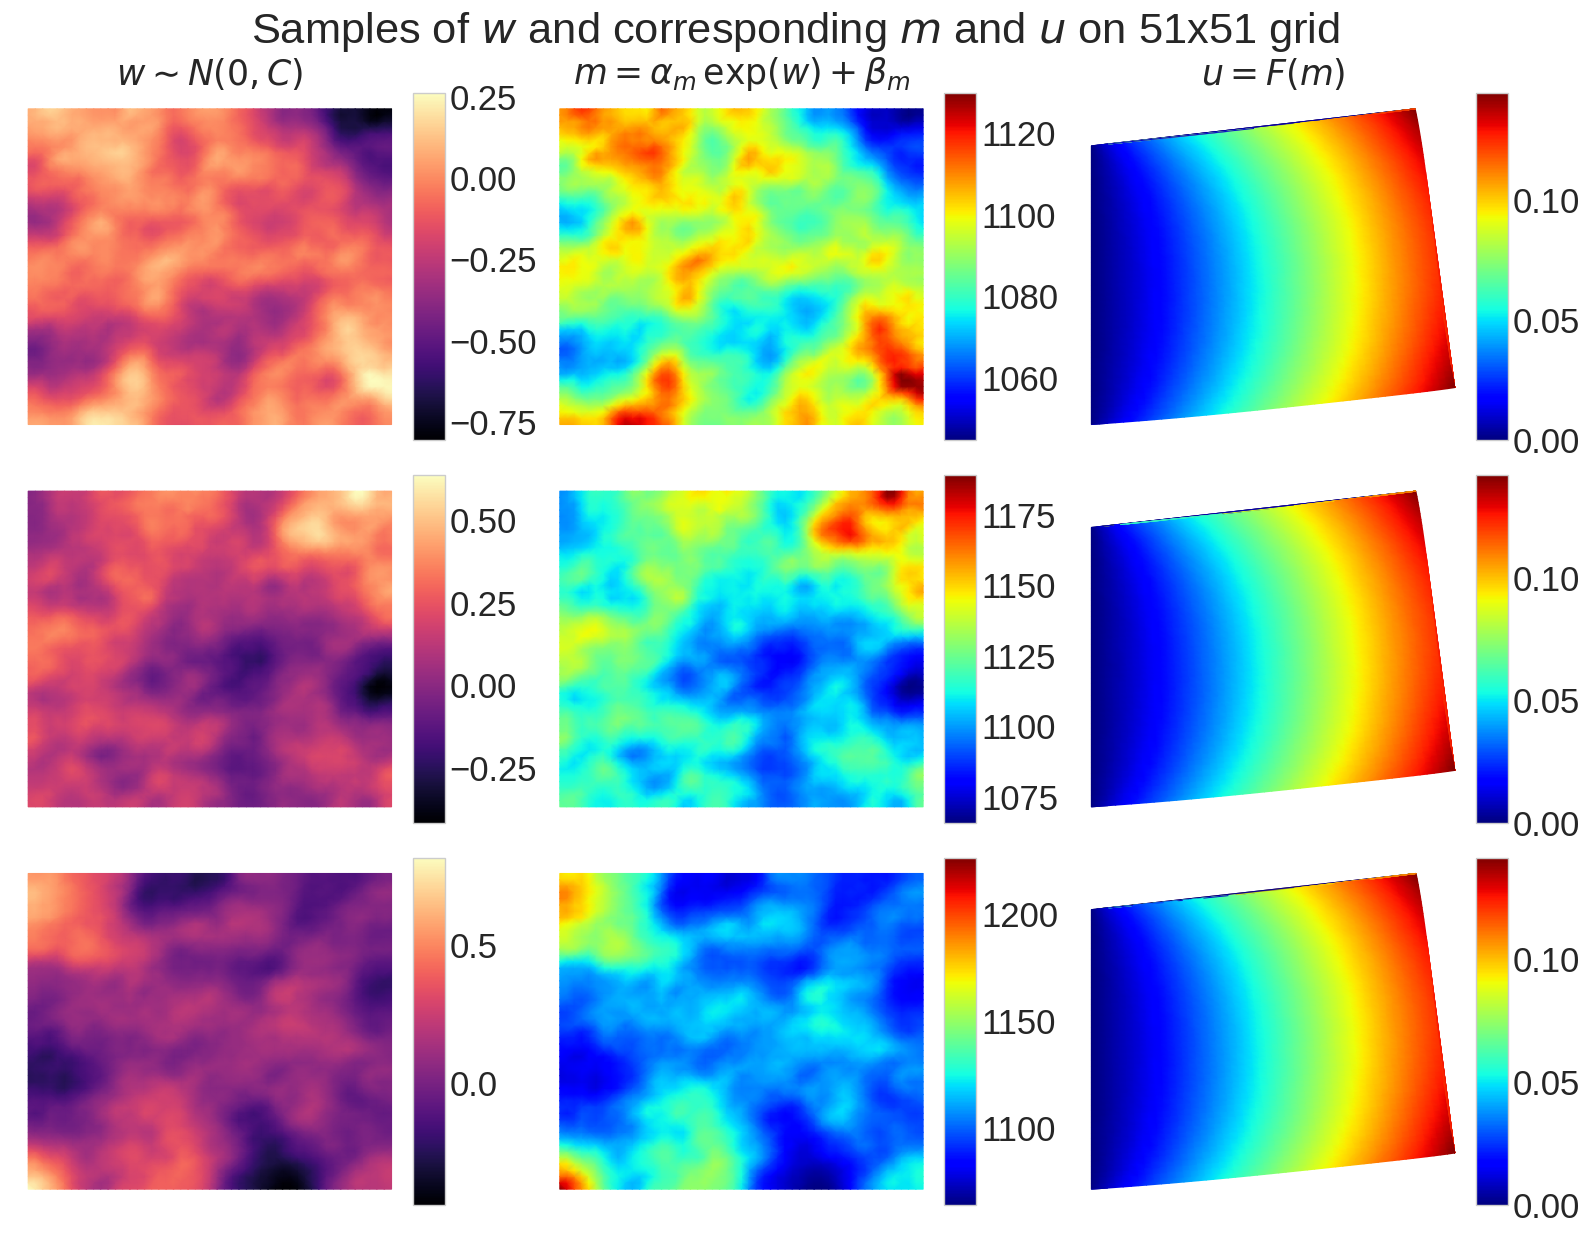

In [17]:
plot_from_data = True
if plot_from_data:
    if generate_fno_data == False:
        data_load = np.load(results_dir + data_prefix + '_FNO_samples.npz')
        grid_w_samples = data_load['grid_w_samples']
        grid_m_samples = data_load['grid_m_samples']
        grid_u_samples = data_load['grid_u_samples']
        grid_x = data_load['grid_x']
        grid_y = data_load['grid_y']
        num_grid_x = grid_x.shape[0]
        num_grid_y = grid_y.shape[1]
    
    i_choices = np.random.choice(w_samples.shape[0], 3, replace=False)

    n_test_samples = len(i_choices)

    print('grid_u_samples shape:', grid_u_samples.shape)  

    u_vec = []
    title_vec = []
    cmapvec = []
    flag_is_vec = []
    flag_add_disp = []
    plot_type = []
    for i in range(n_test_samples): 
        cmapvec.append(['magma', 'jet', 'jet'])
        if i == 0:
            title_vec.append([r'$w \sim N(0, C)$', r'$m = \alpha_m\, \exp(w) + \beta_m$', r'$u = F(m)$'])
        else:
            title_vec.append([None, None, None])
        
        flag_is_vec.append([False, False, True])
        flag_add_disp.append([False, False, True])
        plot_type.append(['grid' for i in range(3)])

        ii = i_choices[i]
        u_vec.append([grid_w_samples[ii], grid_m_samples[ii], grid_u_samples[ii]])


    # plot all samples
    plot_data = get_default_plot_mix_collection_data(rows = n_test_samples, \
        cols = 3, \
        nodes = None, \
        grid_x = grid_x, \
        grid_y = grid_y, \
        figsize = (16, 12), fs = 25, \
        sup_title = r'Samples of $w$ and corresponding $m$ and $u$ on {}x{} grid'.format(num_grid_x, num_grid_y), \
        y_sup_title = 1.025, \
        savefilename = results_dir + data_prefix + '_sample_plots_on_grid.png', \
        u = u_vec, cmap = cmapvec, title = title_vec, \
        is_vec = flag_is_vec, add_disp = flag_add_disp, \
        plot_type = plot_type)

    plot_mix_collection(plot_data)

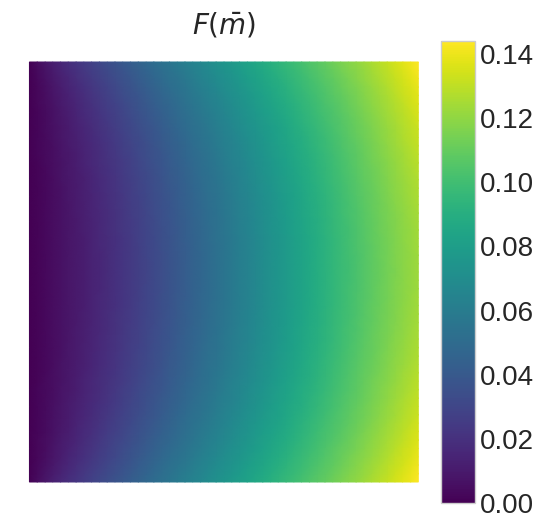

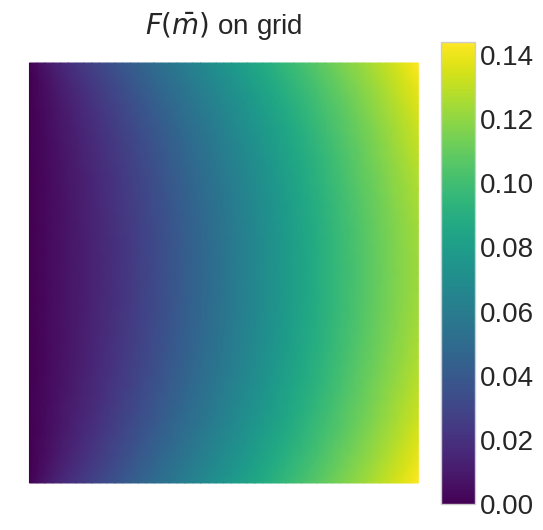

In [20]:
u_mean = model.solveFwd(u = None, m = model.m_mean, transform_m = False)
u_mean = u_samples[0, :]
quick_field_plot(u_mean, model.u_nodes, title=r'$F(\bar{m})$', cmap ='viridis', is_displacement=True)

grid_u_mean = np.zeros((num_grid_x, num_grid_y, 2))
grid_u_mean[:, :, 0] = griddata(u_nodes, u_mean[:num_nodes], (grid_x, grid_y), method='linear')
grid_u_mean[:, :, 1] = griddata(u_nodes, u_mean[num_nodes:], (grid_x, grid_y), method='linear')
quick_field_plot_grid(grid_u_mean, grid_x, grid_y, title=r'$F(\bar{m})$ on grid', cmap ='viridis', is_displacement=True)

In [21]:
# data to save
if generate_fno_data:
        np.savez(results_dir + data_prefix + '_FNO_samples.npz', \
                grid_w_samples = grid_w_samples, \
                grid_m_samples = grid_m_samples, \
                grid_u_samples = grid_u_samples, \
                num_samples = num_samples, \
                num_grid_x = num_grid_x, num_grid_y = num_grid_y, \
                grid_x = grid_x, grid_y = grid_y, \
                u_grid_dirichlet_boundary_nodes = u_grid_dirichlet_boundary_nodes)

### Load data to test

In [22]:
data_load = np.load(results_dir + data_prefix + '_samples.npz')

print('num_samples: {}\nm_samples shape: {}\nu_samples shape: {}\nm_dim: {}\nu_dim: {}'.format(data_load['num_samples'], data_load['m_samples'].shape, data_load['u_samples'].shape, data_load['m_dim'], data_load['u_dim']))

num_samples: 5000
m_samples shape: (5000, 2601)
u_samples shape: (5000, 5202)
m_dim: 2601
u_dim: 5202


In [23]:
fno_data_load = np.load(results_dir + data_prefix + '_FNO_samples.npz')
print('num_samples: {}\ngrid_m_samples shape: {}\ngrid_u_samples shape: {}'.format(fno_data_load['num_samples'], fno_data_load['grid_m_samples'].shape, fno_data_load['grid_u_samples'].shape))

num_samples: 5000
grid_m_samples shape: (5000, 51, 51)
grid_u_samples shape: (5000, 51, 51, 2)
